In [25]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [60]:
def rating_vectorize(rat_dict, n_user, n_item, implicit=False):
    # transform dictionary into matrix
    from torch import zeros

    rat_mat = zeros(n_user, n_item)

    if not implicit:
        for u in rat_dict:
            for i in rat_dict[u]:
                rat_mat[u, i] = rat_dict[u][i]
    else:
        for u in rat_dict:
            for i in rat_dict[u]:
                rat_mat[u, i] = 1
    return rat_mat
    

def mf_data_loader(training_dict, negative_sampling=False, batch_size=128
                   , user_size=25 , pos_size=64):
    """
    :param training_dict: dict
    :param negative_sampling: bool
    :param user_size: int
    :param pos_size: int
    :param batch_size: int

    :return: DataLoader with (user, item, rate)
    """
    from random import choices, choice
    from torch.utils.data import DataLoader

    train_data = []
    if not negative_sampling:
        for user in training_dict:
            for item in training_dict[user]:
                train_data.append([user, item, training_dict[user][item]])

    else:
        for _ in range(user_size):
            user = choice(list(training_dict.keys()))
            pos_cands = list(training_dict[user].keys())
            item_vec = choices(pos_cands, k=pos_size)
            rate_vec = [training_dict[user][i] for i in item_vec]
            user_vec = [user] * pos_size
            train_data.extend(zip(user_vec, item_vec, rate_vec))

    return DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# 1 go over all rating pairs
dl_not_rand = mf_data_loader(training_dict=ratings_train_dict)
# 2 randomly picking users and their rated items 
dl_rand = mf_data_loader(training_dict=ratings_train_dict, negative_sampling=True)

len(list(dl_not_rand)), len(list(dl_rand))

(630, 13)

In [88]:
import torch.nn as nn
from torch import Tensor, LongTensor


class PMF(nn.Module):
    def __init__(self, n_user, n_item, k_dim
                 , std_user=0.5, std_item=0.5):
        super(PMF, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # init param
        nn.init.normal_(self.embedding_user.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)

    def forward(self, user, item):
        return (self.embedding_user(user) \
                * self.embedding_item(item)).sum(1)

    def pred_all(self, ):
        return self.embedding_user.weight \
               @ self.embedding_item.weight.T 


class LogisticPMF(nn.Module):
    def __init__(self, n_user, n_item, k_dim
                 , std_user=0.5, std_item=0.5):

        from torch import sigmoid

        super(LogisticPMF, self).__init__()
        # embeddings of interest
        self.embedding_user = nn.Embedding(n_user, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # activation
        self.sigmoid = sigmoid
        # init param
        nn.init.normal_(self.embedding_user.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)
        # scalars
        self.score_min = None
        self.score_max = None

    def fit_score(self, sc_min, sc_max):
        self.score_min = sc_min
        self.score_max = sc_max

    def forward(self, user, item):
        return self.sigmoid(
                    (self.embedding_user(user) \
                    * self.embedding_item(item)).sum(1)) \
               * (self.score_max-self.score_min) \
               + self.score_min

    def pred_all(self, ):
        return self.sigmoid(
                    self.embedding_user.weight \
                    @ self.embedding_item.weight.T) \
               * (self.score_max-self.score_min) \
               + self.score_min


class ConstrainedPMF(nn.Module):
    def __init__(self, n_user, n_item, k_dim
                 , std_user=1, std_item=1):
        from torch import sigmoid

        super(ConstrainedPMF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        # embeddings of interest
        self.user_offset = nn.Embedding(n_user, 1)
        self.user_latent = nn.Embedding(n_item, k_dim)
        self.embedding_item = nn.Embedding(n_item, k_dim)
        # activation
        self.sigmoid = sigmoid
        # init param
        nn.init.ones_(self.user_offset.weight)
        nn.init.normal_(self.user_latent.weight, mean=0, std=std_user)
        nn.init.normal_(self.embedding_item.weight, mean=0, std=std_item)
        # rating history
        self.rat_mat = None
        # scalars
        self.score_min = None
        self.score_max = None

    def fit_score(self, sc_min, sc_max):
        self.score_min = sc_min
        self.score_max = sc_max

    def set_rat_mat(self, rat_dict):
        self.rat_mat = rating_vectorize(rat_dict, self.n_user, self.n_item, implicit=True)

    def forward(self, user, item):
        avg_counts = self.rat_mat[user].sum(1).view(-1, 1) # match rownum
        # user_emb: (batch_user_num, k_dim)
        user_emb = self.user_offset(user) \
                   + self.rat_mat[user] @ self.user_latent.weight / avg_counts

        return self.sigmoid(
                    (user_emb * self.embedding_item(item)).sum(1)) \
               * (self.score_max-self.score_min) \
               + self.score_min

    def pred_all(self, ):
        avg_counts = self.rat_mat.sum(1).view(-1, 1)
        user_emb = self.user_offset.weight \
                   + self.rat_mat @ self.user_latent.weight / avg_counts
        return self.sigmoid(
                   user_emb 
                   @ self.embedding_item.weight.T) \
               * (self.score_max-self.score_min) \
               + self.score_min



In [90]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np

def SE(input:Tensor, target:Tensor):
    # Squared Error
    return (input-target)**2


def maskedSE(input:Tensor, target:Tensor):
    # Compute squared error for testing set
    mask = (target!=0)

    return ((input[mask]-target[mask])**2)


def train_model(model, opt, rat_train, rat_test, use_cuda, n_epochs, report_interval):
    test_mat = rating_vectorize(rat_test, n_user, n_item)
    
    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
        test_mat = test_mat.to(compute_device)
    else:
        compute_device = device('cpu')

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = mf_data_loader(rat_train)

        ep_loss = []
        for i, batch in enumerate(train_data):
            user, item, score = batch

            model.zero_grad()

            user = autograd.Variable(LongTensor(user)).to(compute_device)
            item = autograd.Variable(LongTensor(item)).to(compute_device)
            score = autograd.Variable(score).to(compute_device)

            preds = model(user, item)
            loss = SE(input=preds, target=score)

            loss.mean().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())
            
        train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))

        # test
        preds = model.pred_all()
        test_rmse = maskedSE(preds, test_mat).mean().sqrt()
        test_rmse_by_ep.append(test_rmse.data.to(compute_device).tolist())

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep


# parameters for model
K_DIM = 16
USE_CUDA = False
N_EPOCHS = 32
REPORT_INTERVAL = 4


""" 1. PMF """
pmf = PMF(n_user, n_item, K_DIM, std_user=0.5, std_item=0.5)
pmf_opt = optim.Adam(pmf.parameters(), lr=0.001, weight_decay=1e-7)
# train model
pmf, pmf_train_loss_by_ep, pmf_test_rmse_by_ep = train_model(
    pmf, pmf_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)


""" 2. Logistic PMF """
scores = [item for user in ratings_train_dict
               for item in ratings_train_dict[user].values()]
sc_min, sc_max = min(scores), max(scores)
lpmf = LogisticPMF(n_user, n_item, K_DIM, std_user=0.5, std_item=0.5)
lpmf.fit_score(sc_min, sc_max)
lpmf_opt = optim.Adam(lpmf.parameters(), lr=0.001, weight_decay=1e-7)
# train model
lpmf, lpmf_train_loss_by_ep, lpmf_test_rmse_by_ep = train_model(
    lpmf, lpmf_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)


""" 3. Constrained PMF """
scores = [item for user in ratings_train_dict
               for item in ratings_train_dict[user].values()]
sc_min, sc_max = min(scores), max(scores)
cpmf = ConstrainedPMF(n_user, n_item, K_DIM, std_user=0.5, std_item=0.5)
cpmf.fit_score(sc_min, sc_max)
cpmf.set_rat_mat(ratings_train_dict)
cpmf_opt = optim.Adam(cpmf.parameters(), lr=0.001, weight_decay=1e-7)
# train model
cpmf, cpmf_train_loss_by_ep, cpmf_test_rmse_by_ep = train_model(
    cpmf, cpmf_opt
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)

Epoch: 4, Time: 116.72,  /Average train loss 3.66799
			/Average test loss 3.98948
Epoch: 8, Time: 6.16,  /Average train loss 2.92979
			/Average test loss 3.24322
Epoch: 12, Time: 6.15,  /Average train loss 1.56091
			/Average test loss 1.94889
Epoch: 16, Time: 7.27,  /Average train loss 1.0285
			/Average test loss 1.50455
Epoch: 20, Time: 8.12,  /Average train loss 0.8239
			/Average test loss 1.34368
Epoch: 24, Time: 7.98,  /Average train loss 0.7232
			/Average test loss 1.27754
Epoch: 28, Time: 8.06,  /Average train loss 0.66408
			/Average test loss 1.2506
Epoch: 32, Time: 8.02,  /Average train loss 0.62369
			/Average test loss 1.24163
Epoch: 4, Time: 6.02,  /Average train loss 1.4242
			/Average test loss 1.4741
Epoch: 8, Time: 22.28,  /Average train loss 1.13896
			/Average test loss 1.26582
Epoch: 12, Time: 63.37,  /Average train loss 0.85549
			/Average test loss 1.00244
Epoch: 16, Time: 28.69,  /Average train loss 0.71699
			/Average test loss 0.91475
Epoch: 20, Time: 8.64

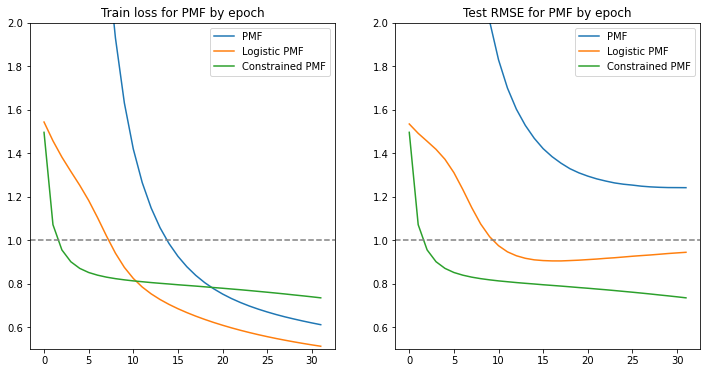

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cut your window in 1 row and 2 columns, and start a plot in the first part
plt.subplot(121)
plt.plot(list(range(N_EPOCHS)), pmf_train_loss_by_ep)
plt.plot(list(range(N_EPOCHS)), lpmf_train_loss_by_ep)
plt.plot(list(range(N_EPOCHS)), cpmf_train_loss_by_ep)

plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['PMF', 'Logistic PMF', 'Constrained PMF'])
plt.title("Train loss for PMF by epoch")
plt.ylim([0.5, 2])

# And now add something in the second part:
plt.subplot(122)
plt.plot(list(range(N_EPOCHS)), pmf_test_rmse_by_ep)
plt.plot(list(range(N_EPOCHS)), lpmf_test_rmse_by_ep)
plt.plot(list(range(N_EPOCHS)), cpmf_train_loss_by_ep)

plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['PMF', 'Logistic PMF', 'Constrained PMF'])
plt.title("Test RMSE for PMF by epoch")
plt.ylim([0.5, 2])

# Show the graph
plt.show()